# Generative Adversarial Networks: the Basics

Generative Adversarial Networks (GANs) represents one of the most exciting recent innovation in deep learning. GANs were originally introduced by Ian Goodfellow and Yoshua Bengio from the University of Montreal, in 2014 and Yann LeCun considered them as ‘the most interesting idea in the last 10 years in ML’ .

A GAN is a generative model in which two neural networks are competing in a typical game theory scenario. The first neural network is the generator, responsible of generating new synthetic data instances that resemble your training data, while its adversary, the discriminator tries to distinguish between real (training) and fake (artificially generated) samples generated by the generator. The mission of the generator is to try fooling the discriminator, and the discriminator tries to resist from being fooled. That’s why the system as a whole is described as adversarial. ([Source](https://towardsdatascience.com/generative-adversarial-networks-gans-2231c5943b11))


<img src="https://miro.medium.com/max/2000/1*XKanAdkjQbg1eDDMF2-4ow.png" alt="gan.png" style="width: 700px;"/>

<img src="https://miro.medium.com/max/1400/1*FbQLpEVQKsMSK-c7_5KcWw.png" alt="gan.png" style="width: 700px;"/>

([Source](https://towardsdatascience.com/generative-adversarial-networks-explained-34472718707a))




* Further reading:

    💡 [ThisXDoesNotExist.com](https://thisxdoesnotexist.com/) displays realistic and diverse contents generated by GANs.

    💡 [NIPS 2016 Tutorial:Generative Adversarial Networks](https://arxiv.org/pdf/1701.00160.pdf).


In this notebook, we will train a GAN to generate handwritten digits based on the `mnist-digits` dataset. This notebook is adapted from the [TensorFlow tutorial on GANs](https://www.tensorflow.org/tutorials/generative/dcgan). 

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import matplotlib.pyplot as plt
import time
plt.style.use('ggplot')

Using TensorFlow v2.6.0


---

# The Dataset

We start by loading the `mnist` dataset.

In [2]:
# load dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# normalise images to [-1, 1]
train_images = train_images / 255.0 * 2 - 1.
test_images = test_images / 255.0 * 2 - 1.

# print info
print("Number of training data: %d" % len(train_labels))
print("Number of test data: %d" % len(test_labels))
print("Image pixels: %s" % str(train_images[0].shape))
print("Number of classes: %d" % (np.max(train_labels) + 1))

11501568/11490434 [==============================] - 0s 0us/step
Number of training data: 60000
Number of test data: 10000
Image pixels: (28, 28)
Number of classes: 10


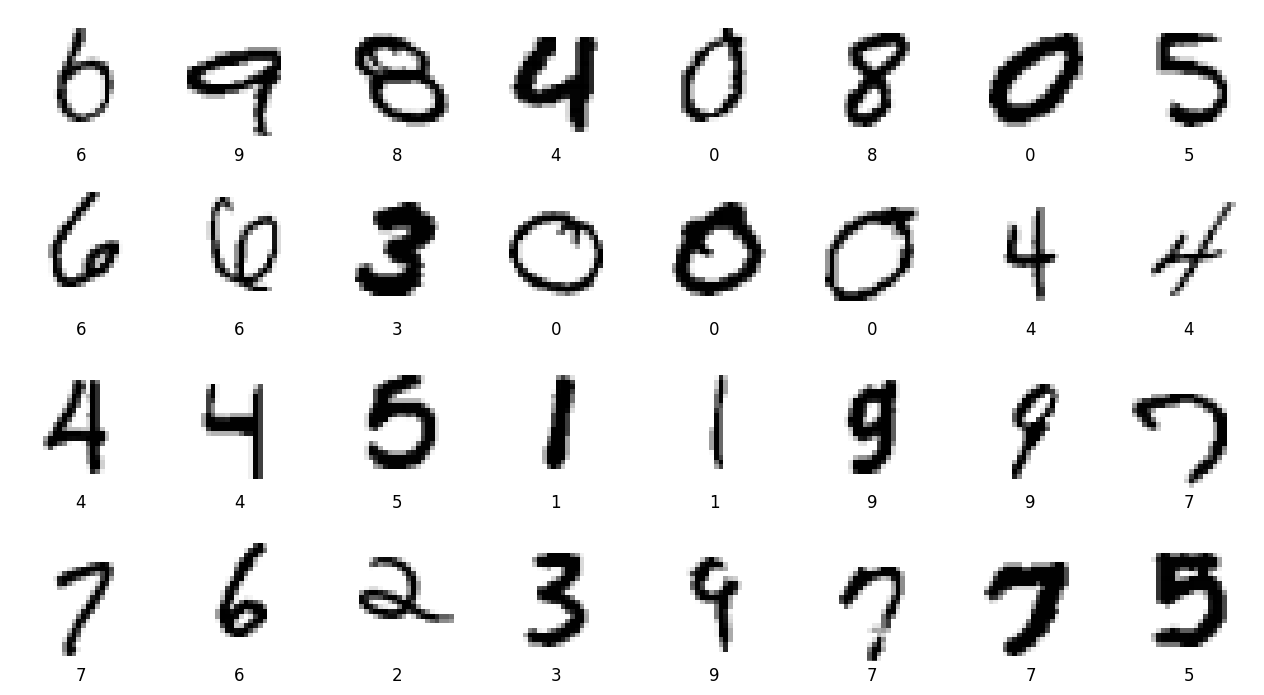

In [3]:
# function to plot an image in a subplot
def subplot_image(image, label, nrows=1, ncols=1, iplot=0, label2='', label2_color='r'):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label, c='k', fontsize=12)
    plt.title(label2, c=label2_color, fontsize=12, y=-0.33)
    plt.xticks([])
    plt.yticks([])
    
# ramdomly plot some images and their labels
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(train_labels), nrows * ncols)):
    subplot_image(train_images[idata], train_labels[idata], nrows, ncols, iplot)
plt.show()

---

# Create a GAN

### The generator

First, we create the generator network. The generator generates an image by upsampling a **seed** (a random noise vector) several times. Each upsampling is conducted by a `Conv2DTranspose` layer. We start with a `Dense` layer that upscales the seed into a proper size such that it can be reshaped into a stack of small images; next, several `Conv2DTranspose` layers are followed to upsample the small images into the original image size. All layers use `LeakyReLU` for activation except the output layer, which uses `tanh` (note that we have normalised the pixel values to [-1, 1] in the previous section).

**Takeaway**: the generator transforms a seed (a random noise vector) into an image.

In [4]:
def make_generator_model(noise_size=100, image_size=(28,28), n_filters=(256,128,64)):
    '''
    Create a generator, hardcoded with three Conv2DTranspose layers.
    
    :param noise_size: size of the seed vector
    :param image_size: size of the image (both width and height must divide 4)
    :param n_filters: number of filters in each layer
    :return: the generator model
    '''
    
    # sequential model
    model = tf.keras.Sequential()
    
    # Dense
    # input shape: (100,)
    # output shape: (7*7*256,)
    w = image_size[0] // 4
    h = image_size[1] // 4
    model.add(layers.Dense(w*h*n_filters[0], use_bias=False, 
                           input_shape=(noise_size,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape
    # input shape: (7*7*256,)
    # output shape: (7, 7, 256)
    model.add(layers.Reshape((w, h, n_filters[0])))

    # Conv2DTranspose
    # input shape: (7, 7, 256)
    # output shape: (7, 7, 128)
    model.add(layers.Conv2DTranspose(n_filters[1], (5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose
    # input shape: (7, 7, 128)
    # output shape: (14, 14, 64)
    model.add(layers.Conv2DTranspose(n_filters[2], (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose
    # input shape: (14, 14, 64)
    # output shape: (28, 28, 1)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False, activation='tanh'))
    
    # input: (100,)
    # output: (28, 28, 1)
    return model

Here we can use the **untrained** generator to generate an image. This is helpful to validate the layer sizes in the generator.

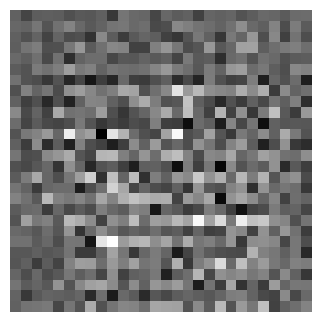

In [5]:
# noise size
NOISE_SIZE = 100
IMAGE_SIZE = (28, 28)
N_FILTERS = (256, 128, 64)

# create a generator
generator = make_generator_model(noise_size=NOISE_SIZE, image_size=IMAGE_SIZE, n_filters=N_FILTERS)

# seed
seed = tf.random.normal([1, NOISE_SIZE])

# generate and plot the image
generated_image = generator(seed, training=False)
plt.figure(dpi=100)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

### The discriminator

Next, we create the discriminator network. The discriminator takes an image and downsample it into a single real number between 0 and 1. The output being 0 means the discriminator classifies the image as fake, and 1 as real. We use `Conv2D` to downsample the images. 

**Takeaway**: the discriminator transforms an image into a real number.

In [6]:
def make_discriminator_model(image_size=(28,28), n_filters=(64,128)):
    '''
    Create a discriminator, hardcoded with two Conv2D layers.
    
    :param image_size: size of the image (both width and height must divide 4)
    :param n_filters: number of filters in each layer
    :return: the discriminator model
    '''
    
    # sequential model
    model = tf.keras.Sequential()
    
    # Conv2D
    # input shape: (28, 28, 1)
    # output shape: (14, 14, 64)
    w = image_size[0]
    h = image_size[1]
    model.add(layers.Conv2D(n_filters[0], (5, 5), strides=(2, 2), padding='same',
              input_shape=[w, h, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Conv2D
    # input shape: (14, 14, 64)
    # output shape: (7, 7, 128)
    model.add(layers.Conv2D(n_filters[1], (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten
    # input shape: (7, 7, 128)
    # output shape: (7*7*128,)
    model.add(layers.Flatten())
    
    # 4th layer: Dense
    # input shape: (7*7*128,)
    # output shape: (1,)
    model.add(layers.Dense(1))
    
    # input: (28, 28, 1)
    # output: (1,)
    return model

Again, for size validation,  we can use the **untrained** discriminator to check the image we just generated. Note that we do not use `sigmoid` as the activation function of the last layer, so the output does not necessarily range between 0 and 1. Using `sigmoid` is also correct, but it slows down convergence at the early stage of training (as we want to save some time in this course).

In [7]:
# create a discriminator
discriminator = make_discriminator_model(image_size=(28,28), n_filters=(64,128))

# check an image
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00045567]], shape=(1, 1), dtype=float32)


### Loss functions

This discriminator's loss quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [8]:
# cross entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# discriminator's loss 
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# generator's loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizers

The optimizer hyperparameters for the generator and the discriminator can be different. Here we use the same ones.

In [9]:
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

---

# Training Loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [10]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(real_images, noise_size):
    # seed
    batch_size = real_images.shape[0]
    seed = tf.random.normal([batch_size, noise_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # fake images
        fake_images = generator(seed, training=True)
        
        # discriminate real
        real_score = discriminator(real_images, training=True)
        # discriminate fake
        fake_score = discriminator(fake_images, training=True)

        # compute losses
        gen_loss = generator_loss(fake_score)
        disc_loss = discriminator_loss(real_score, fake_score)
        
        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        # apply gradients to update model parameters
        generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
        
        return gen_loss, disc_loss

Next, we make a Tensorflow dataset from the raw image data:

In [11]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(np.expand_dims(train_images.astype('float32'), -1))
train_dataset = train_dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE)

Now we can train the model. GANs converge slowly in general. Here we only do 50 epochs, after which the generated images start to resemble handwritten digits. Do more epochs to reach a better quality.

In [12]:
############################
######### TRAINING #########
############################

# epochs
EPOCHS = 50

# epoch loop
tstart = time.time()
for epoch in range(EPOCHS):
    # batch loop
    for i, image_batch in enumerate(train_dataset):
        gen_loss, disc_loss = train_step(image_batch, NOISE_SIZE)
    # print loss after each epoch
    print(f'Epoch {epoch + 1} / {EPOCHS}, Elapsed = {time.time() - tstart:.2f} s, '
          f'Gen loss = {gen_loss:.2f}, Disc loss = {disc_loss:.2f}')

Epoch 1 / 50, Elapsed = 28.93 s, Gen loss = 0.77, Disc loss = 1.34
Epoch 2 / 50, Elapsed = 54.58 s, Gen loss = 0.88, Disc loss = 1.06
Epoch 3 / 50, Elapsed = 80.21 s, Gen loss = 0.68, Disc loss = 1.49
Epoch 4 / 50, Elapsed = 105.75 s, Gen loss = 1.15, Disc loss = 0.96
Epoch 5 / 50, Elapsed = 131.31 s, Gen loss = 0.75, Disc loss = 1.60
Epoch 6 / 50, Elapsed = 156.84 s, Gen loss = 0.94, Disc loss = 1.11
Epoch 7 / 50, Elapsed = 182.40 s, Gen loss = 0.97, Disc loss = 1.14
Epoch 8 / 50, Elapsed = 207.92 s, Gen loss = 0.79, Disc loss = 1.33
Epoch 9 / 50, Elapsed = 233.46 s, Gen loss = 0.98, Disc loss = 1.09
Epoch 10 / 50, Elapsed = 259.06 s, Gen loss = 1.05, Disc loss = 1.05
Epoch 11 / 50, Elapsed = 284.54 s, Gen loss = 1.08, Disc loss = 0.93
Epoch 12 / 50, Elapsed = 310.06 s, Gen loss = 0.80, Disc loss = 1.45
Epoch 13 / 50, Elapsed = 335.57 s, Gen loss = 0.83, Disc loss = 1.43
Epoch 14 / 50, Elapsed = 361.13 s, Gen loss = 0.90, Disc loss = 1.37
Epoch 15 / 50, Elapsed = 386.86 s, Gen loss = 

Finally, we can use the trained generator to generate images from some random noise:

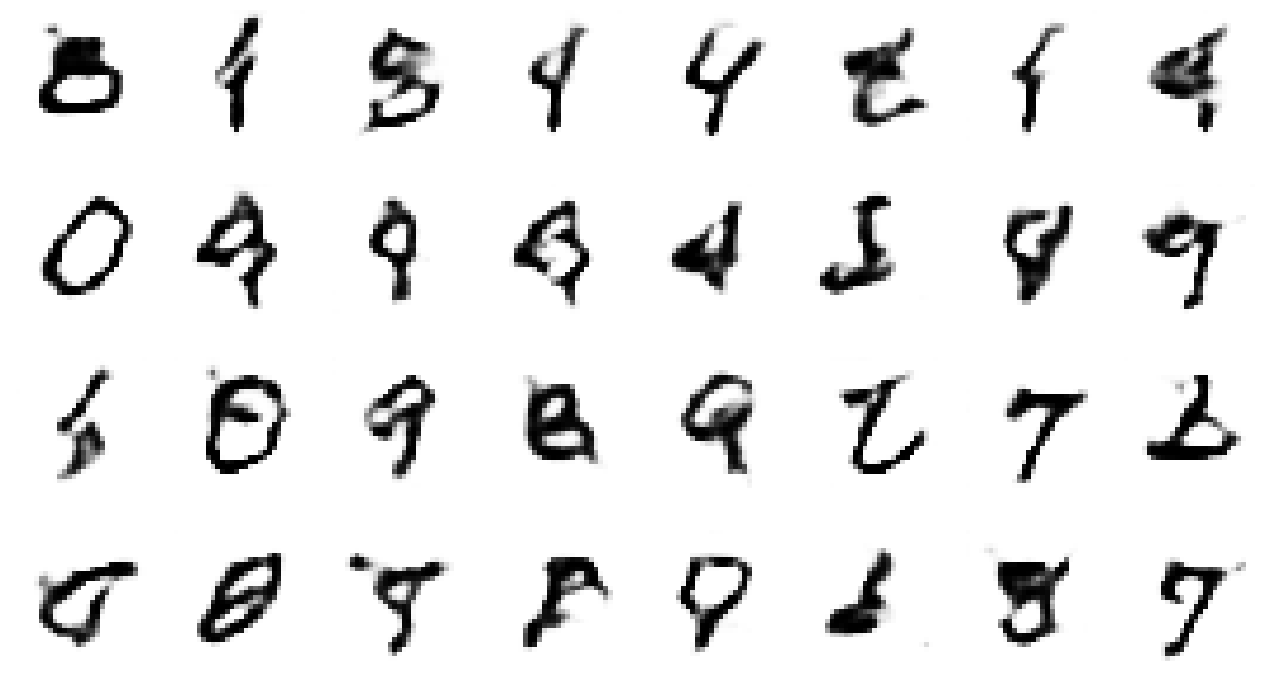

In [13]:
# seed
nrows = 4
ncols = 8
seed = tf.random.normal([nrows * ncols, NOISE_SIZE])

# generate images
generated_image = generator(seed, training=False)

# plot images
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot in range(nrows * ncols):
    subplot_image(generated_image[iplot, :, :, 0], '', nrows, ncols, iplot)
plt.show()

---

## Exercises

### Asynchronous Training
Improve `train_step` into the following form to allow for asynchronous training:

```python
def train_step(real_images, noise_size, update_gen=True, update_disc=True):
    ...
```

Here `update_gen` and `update_disc` are booleans to determine whether the generator and the discriminator should be updated in this step. Next, in the batch loop, use batch index `i` to determine the two booleans; for example, update the discriminator for every `i` and update the generator when `i%2=0`. 


### Wasserstein loss
Implement the wasserstein loss:

* Discriminator loss: $D(x)-D(G(z))$

* Generator loss: $D(G(z))$


### c-GAN
We can extend our GAN into a conditional GAN or c-GAN so that we can specify the number to be generated. We must send the labels (0~9) to both the generator and discriminator.

* For the generator, we can simply concatenate the label to the seed. Therefore, instead of doing

    ```python
    model.add(layers.Dense(w*h*n_filters[0], use_bias=False, 
                           input_shape=(noise_size,)))
    ```

    we can do 

    ```python
    model.add(layers.Dense(w*h*n_filters[0], use_bias=False, 
                           input_shape=(noise_size + 1,)))
    ```
    
    When calling the generator, concatenate the lables to the noise:
    
    ```python
    fake_images = generator(tf.concat((seed, labels), axis=-1), training=True)
    ```

* For the discriminator, it is reported that one should add the labels as early as possible. The input is an image (either data or generated), so we can make the label into a (28, 28) image and append it to the input image as an additional channel, i.e., instead of doing

    ```python
    model.add(layers.Conv2D(n_filters[0], (5, 5), strides=(2, 2), padding='same',
              input_shape=[w, h, 1]))
    ```

    we can do

    ```python
    model.add(layers.Conv2D(n_filters[0], (5, 5), strides=(2, 2), padding='same',
              input_shape=[w, h, 2]))
    ```
    
    When calling the discriminator, concatenate the lables to the images:
    
    ```python
    labels_in_image_shape = tf.tile(tf.reshape(labels, [labels.shape[0], 1, 1, 1]), [1, 28, 28, 1])
    real_score = discriminator(tf.concat((real_images, labels_in_image_shape), axis=-1), training=True)
    fake_score = discriminator(tf.concat((fake_images, labels_in_image_shape), axis=-1), training=True)
    ```
    
* The labels can be added to the TensorFlow dataset by

    ```python
    train_dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(train_images.astype('float32'), -1), 
                                                        np.expand_dims(train_labels.astype('float32'), -1)))
    ```